# Gender Analysis for Vaccination Rate

In [2]:
import pandas as pd
import seaborn as sns
vac_data = pd.read_excel('data/vaccine_city_sex.xlsx', engine='openpyxl')

In [3]:
cities_of_interest = ['Revere', 'Chelsea', 'Newton', 'Wellesley', 'New Bedford']
vac_data = vac_data[vac_data['city'].isin(cities_of_interest)]

vac_data['fully_vac_rate'] = round((vac_data['fully_vaccinated'] / vac_data['population']),2) * 100
vac_data['partially_vac_rate'] = round((vac_data['partially_vaccinated'] / vac_data['population']),2) * 100
vac_data['onedose_vac_rate'] = round((vac_data['atleast_onedose'] / vac_data['population']),2) * 100
vac_data['boosted_rate'] = round((vac_data['boosted'] / vac_data['population']),2) * 100

In [4]:
import numpy as np
# Custom function to apply to each row
def check_vac(row):
    vaccination_columns = ["fully_vaccinated", "atleast_onedose", "boosted", "boosted_second", "partially_vaccinated"]
    for col in vaccination_columns:
        if row[col] > row["population"]:
            row[col] = np.nan
    return row
# Apply the function across the DataFrame row-wise
vac_data = vac_data.apply(check_vac, axis=1)

In [5]:
vac_data['year'] = vac_data['date'].dt.year
vac_data['month'] = vac_data['date'].dt.month
vac_data['year_month'] = vac_data['date'].dt.to_period('M')

#using the max population replace the missing population
vac_data['population'] = vac_data.groupby(['year','city','gender'])['population'].transform(lambda x: x.fillna(x.max()))

#using the max population replace the population
vac_data['population'] = vac_data.groupby(['year','city','gender'])['population'].transform(lambda x: x.max())

In [6]:
filtered_df = vac_data[vac_data['gender'].isin(['Female', 'Male'])]
filtered_df = filtered_df[['year','month','city', 'gender', 'fully_vac_rate']]
filtered_data = filtered_df[(filtered_df['year'] == 2023) & (filtered_df['month'] == 4)]

In [7]:
# 2. transform data into monthly data

# Group by 'year', 'month', 'city', and 'race' and then take the max
monthly_data = vac_data.drop(columns=['date'])
monthly_data = monthly_data.groupby(['year', 'month', 'city', 'gender']).max().reset_index()

print(len(monthly_data))

520


In [8]:
# 3. calculate the vaccination rate
# Calculating vaccination rate
monthly_data['fully_vac_rate'] = round((monthly_data['fully_vaccinated'] / monthly_data['population']),2) * 100
monthly_data['partially_vac_rate'] = round((monthly_data['partially_vaccinated'] / monthly_data['population']),2) * 100
monthly_data['onedose_vac_rate'] = round((monthly_data['atleast_onedose'] / monthly_data['population']),2) * 100
monthly_data['boosted_rate'] = round((monthly_data['boosted'] / monthly_data['population']),2) * 100

monthly_data = monthly_data[~monthly_data['gender'].isin(['Other'])]

monthly_data = monthly_data[~monthly_data['gender'].isin(['Total'])]

In [9]:
# 4. Adjusts the vaccination rates in the DataFrame such that they do not decrease compared to the previous time point.

def adjust_vac_rates_for_all_columns(df, city_col, race_col, time_col, vac_rate_cols):
    """
    Adjusts the vaccination rates in the DataFrame such that they do not decrease compared to the previous time point.

    :return: Modified DataFrame with adjusted vaccination rates.
    """
    # Iterate over each city and race
    for city in df[city_col].unique():
        for race in df[df[city_col] == city][race_col].unique():
            # Filter the data for the current city and race
            city_race_data = df[(df[city_col] == city) & (df[race_col] == race)].copy()
            # Sort by time to ensure chronological order
            city_race_data.sort_values(time_col, inplace=True)
            
            # Iterate over each vaccination rate column to apply the cummax adjustment
            for vac_rate_col in vac_rate_cols:
                city_race_data[vac_rate_col] = city_race_data[vac_rate_col].cummax()
            
            # Update the original DataFrame
            df.update(city_race_data)
    
    # Return the modified DataFrame
    return df

# Usage
vac_columns = ["fully_vac_rate", "onedose_vac_rate", "boosted_rate", "partially_vac_rate"]
monthly_data = adjust_vac_rates_for_all_columns(monthly_data, 'city', 'gender', 'year_month', vac_columns)


In [10]:
# Fillout the missing values with previous next value
def fill_missing_with_next(df, city_col, gender_col, time_col, vac_rate_cols):
    """
    Fills missing values in the vaccination rate columns with the next available non-NaN value.

    :param df: pandas DataFrame containing the data.
    :param vac_rate_cols: List of column names representing different vaccination rates.
    :return: DataFrame with missing values filled.
    """
    # Make a copy of the dataframe to avoid changing the original dataframe
    # Iterate over each city and race
    for city in df[city_col].unique():
        for race in df[df[city_col] == city][gender_col].unique():
            # Filter the data for the current city and race
            city_gender_data = df[(df[city_col] == city) & (df[gender_col] == race)].copy()
            # Sort by time to ensure chronological order
            city_gender_data.sort_values(time_col, inplace=True)
    
    # Iterate over each vaccination rate column and fill NaN values with the next non-NaN value
            for vac_rate_col in vac_rate_cols:
                city_gender_data[vac_rate_col] = city_gender_data[vac_rate_col].fillna(method='bfill')

            df.update(city_gender_data)
    # Update the original DataFrame
    return df

# Usage
vac_columns = ["fully_vac_rate", "onedose_vac_rate", "boosted_rate", "partially_vac_rate"]
monthly_data_filled = fill_missing_with_next(monthly_data, 'city', 'gender', 'year_month', vac_columns)


/var/folders/b1/s_2bdh751d7_gtrtwf3td9wc0000gn/T/ipykernel_64128/1836259686.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  city_gender_data[vac_rate_col] = city_gender_data[vac_rate_col].fillna(method='bfill')


In [11]:
selected_columns_2021_03 = monthly_data_filled[
    (monthly_data_filled['year_month'] == "2021-03")
][['city', 'fully_vac_rate', 'gender', 'year_month']]

# Display the selected columns
print(selected_columns_2021_03)

           city  fully_vac_rate  gender year_month
0       Chelsea            19.0  Female    2021-03
1       Chelsea            13.0    Male    2021-03
4   New Bedford            14.0  Female    2021-03
5   New Bedford             9.0    Male    2021-03
8        Newton            30.0  Female    2021-03
9        Newton            24.0    Male    2021-03
12       Revere            20.0  Female    2021-03
13       Revere            14.0    Male    2021-03
16    Wellesley            20.0  Female    2021-03
17    Wellesley            17.0    Male    2021-03


# Vaccination Rate Comparison Over Cities

<Figure size 800x600 with 0 Axes>

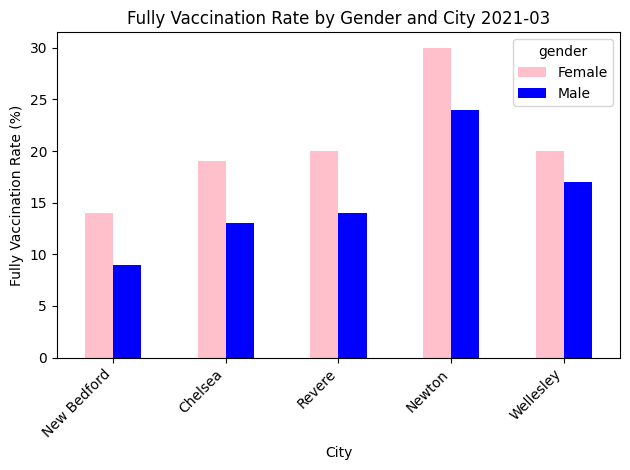

In [12]:
import matplotlib.pyplot as plt

city_order = ["New Bedford", "Chelsea", "Revere", "Newton", "Wellesley"]
selected_columns_2021_03['city'] = pd.Categorical(selected_columns_2021_03['city'], categories=city_order, ordered=True)
selected_columns_2021_03 = selected_columns_2021_03.sort_values('city')

# Pivoting the data for better visualization
pivot_df = selected_columns_2021_03.pivot(index='city', columns='gender', values='fully_vac_rate')

# Plotting
plt.figure(figsize=(8, 6))
pivot_df.plot(kind='bar', color=['pink', 'blue'], title="Fully Vaccination Rate by Gender and City 2021-03")
plt.xticks(rotation=45, ha='right')
plt.ylabel('Fully Vaccination Rate (%)')
plt.xlabel('City')
plt.tight_layout()
plt.show()


In [13]:
selected_columns_2023_03 = monthly_data_filled[
    (monthly_data_filled['year_month'] == "2023-03")
][['city', 'fully_vac_rate', 'gender', 'year_month']]

# Display the selected columns
print(selected_columns_2023_03)

            city  fully_vac_rate  gender year_month
480      Chelsea            86.0  Female    2023-03
481      Chelsea            78.0    Male    2023-03
484  New Bedford            63.0  Female    2023-03
485  New Bedford            59.0    Male    2023-03
488       Newton            98.0  Female    2023-03
489       Newton            97.0    Male    2023-03
492       Revere            81.0  Female    2023-03
493       Revere            76.0    Male    2023-03
496    Wellesley            82.0  Female    2023-03
497    Wellesley            88.0    Male    2023-03


<Figure size 800x600 with 0 Axes>

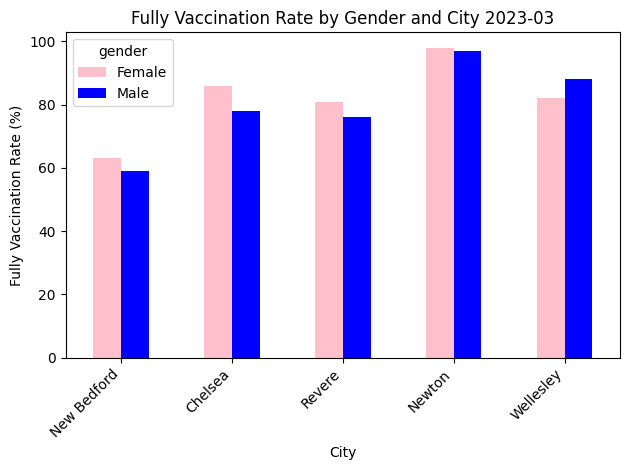

In [16]:
import matplotlib.pyplot as plt

city_order = ["New Bedford", "Chelsea", "Revere", "Newton", "Wellesley"]
selected_columns_2023_03['city'] = pd.Categorical(selected_columns_2023_03['city'], categories=city_order, ordered=True)
selected_columns_2023_03 = selected_columns_2023_03.sort_values('city')

# Pivoting the data for better visualization
pivot_df = selected_columns_2023_03.pivot(index='city', columns='gender', values='fully_vac_rate')

# Plotting
plt.figure(figsize=(8, 6))
pivot_df.plot(kind='bar', color=['pink', 'blue'], title="Fully Vaccination Rate by Gender and City 2023-03")
plt.xticks(rotation=45, ha='right')
plt.ylabel('Fully Vaccination Rate (%)')
plt.xlabel('City')
plt.tight_layout()
plt.show()



In [17]:
#save to the csv file
monthly_data_filled.to_csv('data/gender_monthly_data.csv', index=True)

/var/folders/b1/s_2bdh751d7_gtrtwf3td9wc0000gn/T/ipykernel_72596/451750172.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_vac_rate_by_city_gender = monthly_data_filled.groupby(['city', 'gender'])['fully_vac_rate'].mean()


<Figure size 800x600 with 0 Axes>

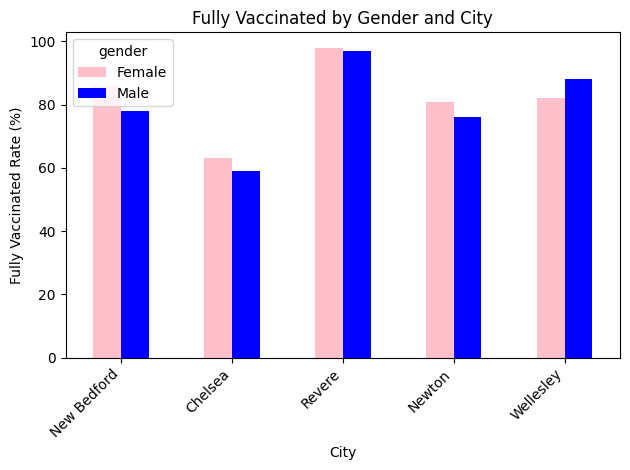

In [383]:
# Calculate the average of vaccination rate by city and gender
average_vac_rate_by_city_gender = monthly_data_filled.groupby(['city', 'gender'])['fully_vac_rate'].mean()

average_vac_rate_by_city_gender

# Plotting
plt.figure(figsize=(8, 6))
pivot_df.plot(kind='bar', color=['pink', 'blue'], title="Fully Vaccinated by Gender and City")
plt.xticks(rotation=45, ha='right')
plt.ylabel('Fully Vaccinated Rate (%)')
plt.xlabel('City')
plt.tight_layout()
plt.show()

/var/folders/b1/s_2bdh751d7_gtrtwf3td9wc0000gn/T/ipykernel_64128/662019421.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='city', y='fully_vac_rate', hue='gender', data=monthly_data_filled,


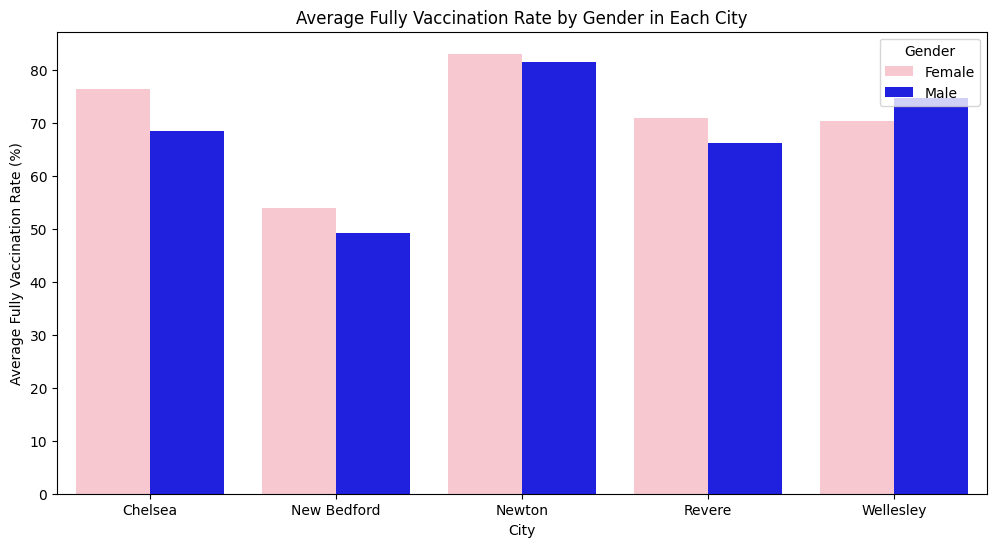

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Creating a bar plot for the average vaccination rate by gender in each city
plt.figure(figsize=(12, 6))
sns.barplot(x='city', y='fully_vac_rate', hue='gender', data=monthly_data_filled, 
            estimator=np.mean, ci=None, palette={'Male': 'blue', 'Female': 'pink'})

plt.title('Average Fully Vaccination Rate by Gender in Each City')
plt.xlabel('City')
plt.ylabel('Average Fully Vaccination Rate (%)')
plt.legend(title='Gender')
plt.show()


/var/folders/b1/s_2bdh751d7_gtrtwf3td9wc0000gn/T/ipykernel_64128/2465496533.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data= monthly_data_filled, x='year_month', y='fully_vac_rate', hue='gender', marker='o', ci=None, palette=palette)


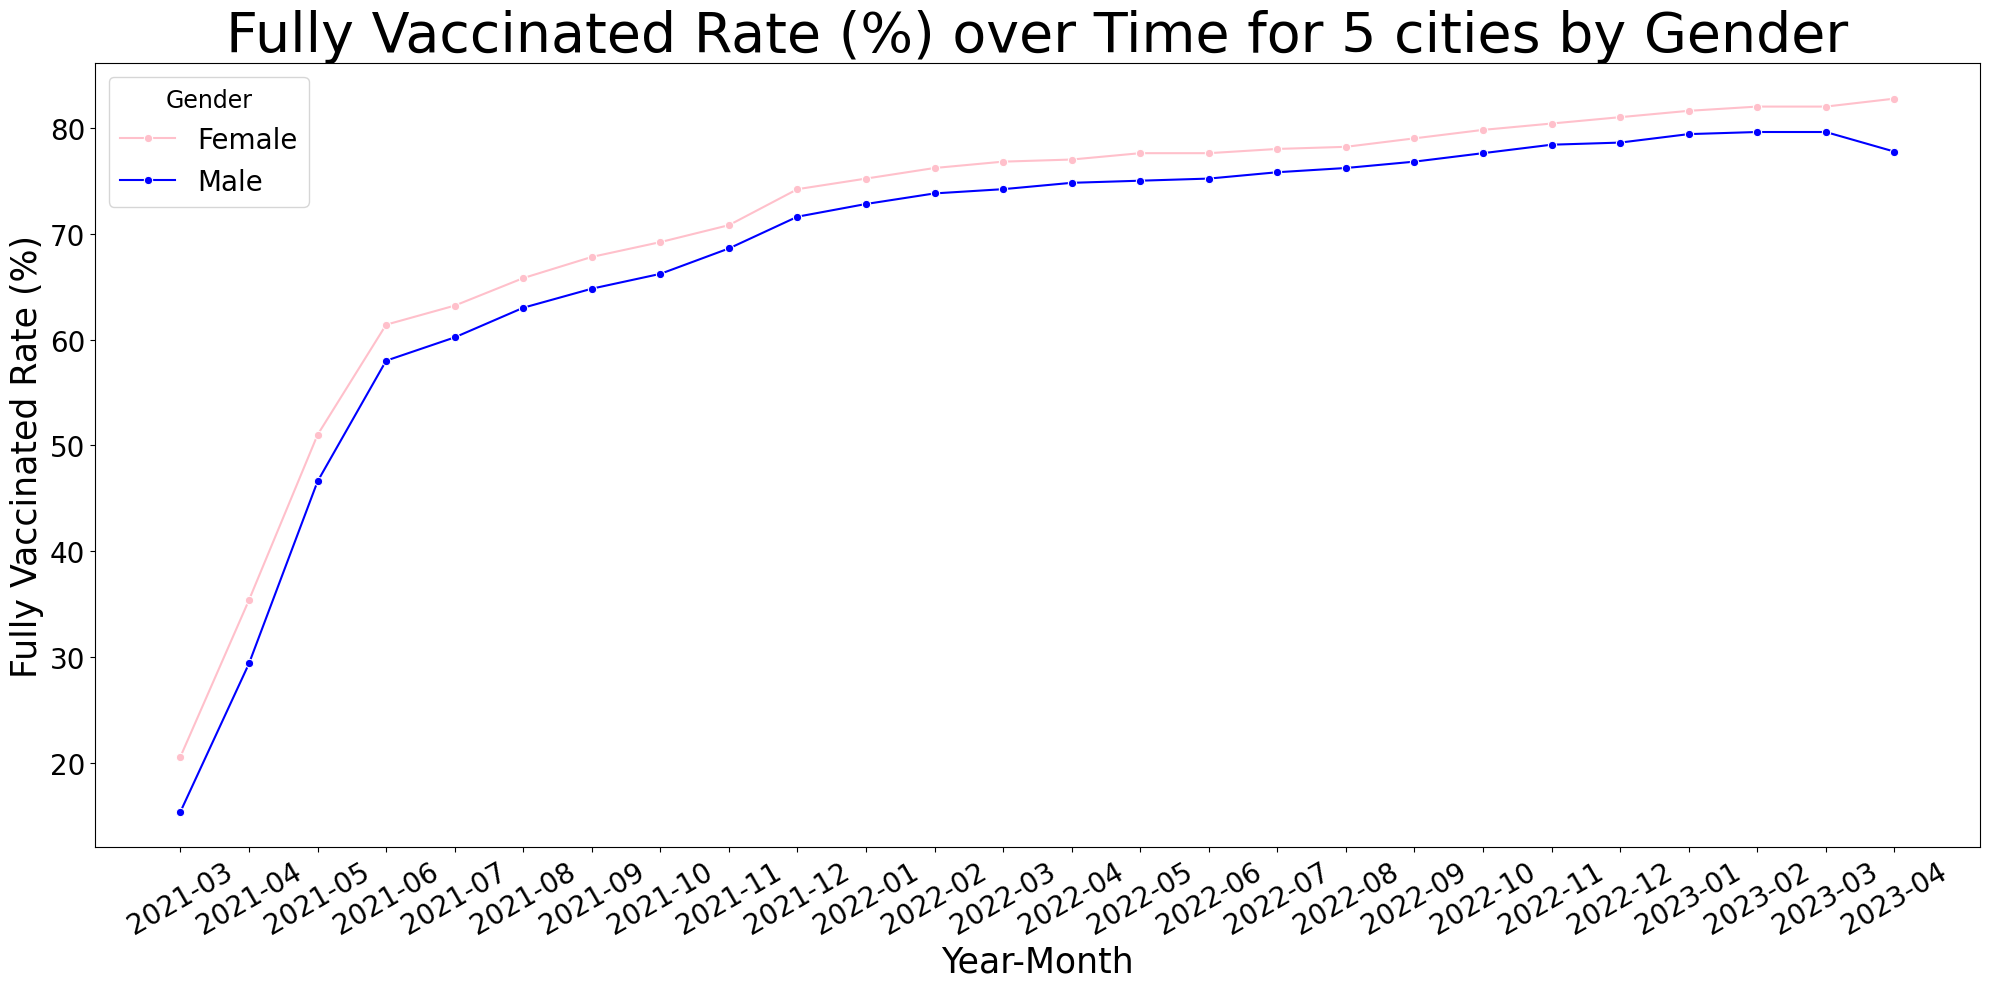

In [19]:
# Plotting fully_vac rate
plt.figure(figsize=(20, 10))
#sns.lineplot(data=df_filtered, x='date', y='vaccination_rate', hue='city', style='race')
monthly_data_filled['year_month'] = monthly_data_filled['year_month'].astype(str)

palette = {"Male": "blue", "Female": "pink"}
sns.lineplot(data= monthly_data_filled, x='year_month', y='fully_vac_rate', hue='gender', marker='o', ci=None, palette=palette)

# Adjusting x-axis for better readability

plt.xticks(rotation=30)

# Set title and labels
plt.title('Fully Vaccinated Rate (%) over Time for 5 cities by Gender', fontsize = 40)
plt.ylabel('Fully Vaccinated Rate (%)', fontsize = 25)
plt.xlabel('Year-Month', fontsize = 25)

# adjust the tick labels and legend
plt.xticks(rotation = 30, fontsize =20)
plt.yticks(fontsize = 20)
plt.legend(title='Gender', title_fontsize = '17', fontsize = 20, loc = 'upper left')


plt.tight_layout()


plt.savefig('./fully_vac_by_gender.png')

plt.show()

# Linear Regression for Gender vs Vaccination Rate

In [379]:
import statsmodels.formula.api as smf
# Constructing the linear regression model
monthly_data_filled['gender'] = pd.Categorical(monthly_data_filled['gender'], categories=['Male', 'Female'], ordered=True)

formula = 'fully_vac_rate ~ gender + city'
model = smf.ols(formula, data=monthly_data_filled).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         fully_vac_rate   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                     21.63
Date:                Mon, 11 Dec 2023   Prob (F-statistic):           5.27e-18
Time:                        16:56:45   Log-Likelihood:                -1071.7
No. Observations:                 258   AIC:                             2155.
Df Residuals:                     252   BIC:                             2177.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              71.0236    

In [380]:
female_population = monthly_data_filled[monthly_data_filled['gender'] == 'Female'][['year', 'month', 'city', 'population']]

# Step 2: Group by 'year', 'month', and 'city' to get the total female population
female_population_grouped = female_population.groupby(['year', 'month', 'city']).sum().reset_index()

# Step 3: Merge this grouped data back into the original DataFrame
new_df = monthly_data_filled.merge(female_population_grouped, on=['year', 'month', 'city'], how='left', suffixes=('', '_female'))


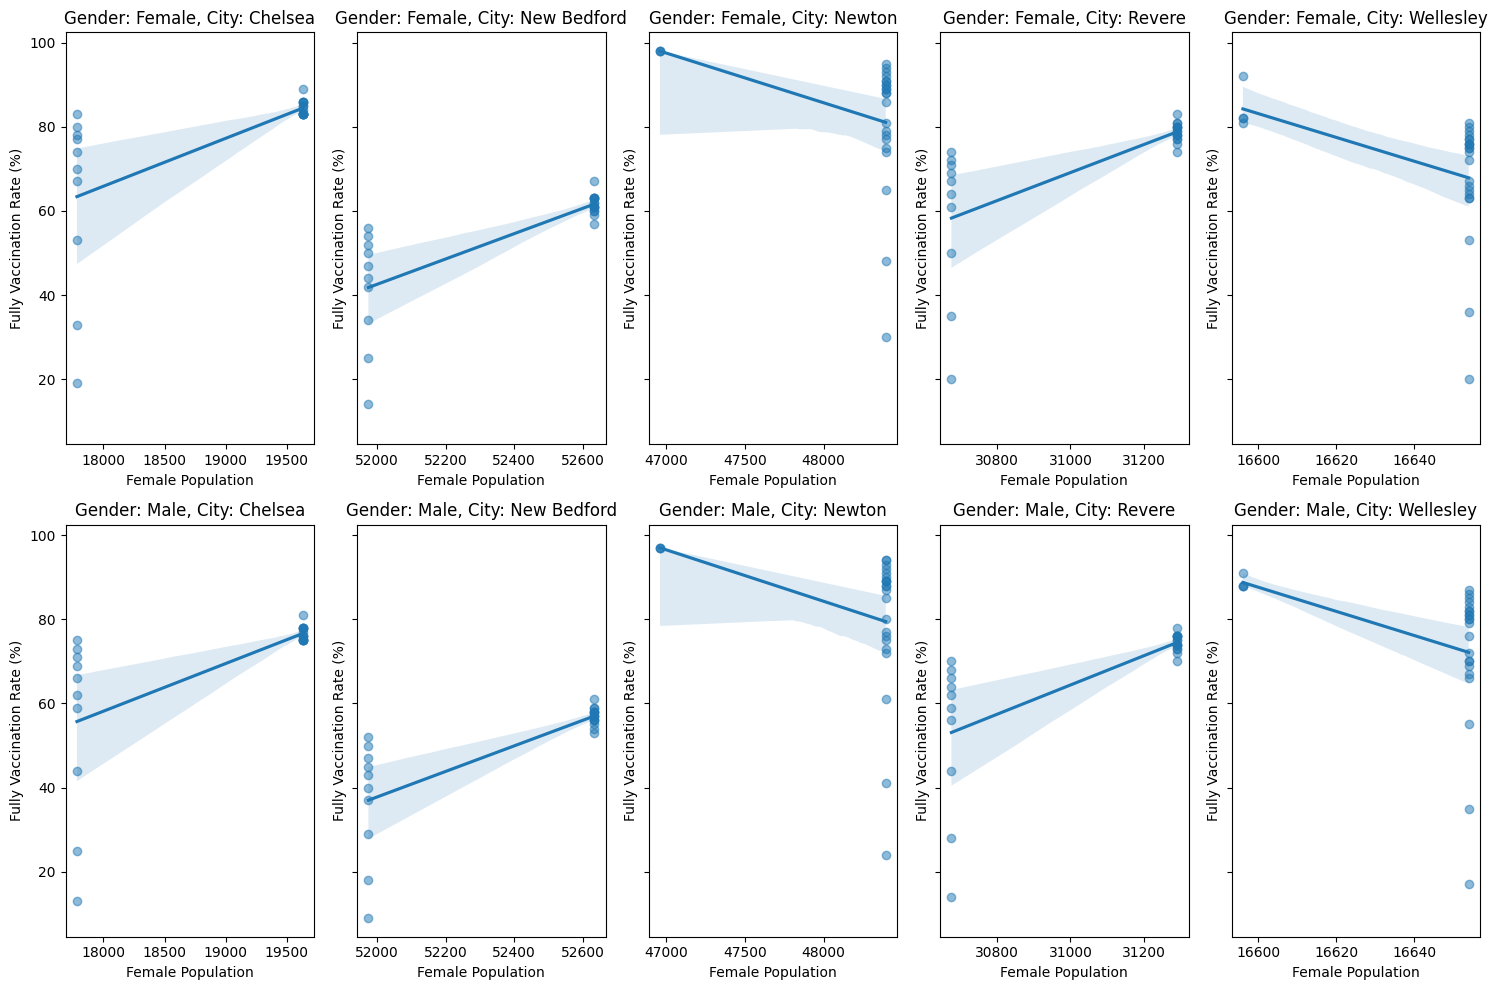

In [381]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'population_female' is a numeric predictor in your model
# and 'monthly_data_filled' is your DataFrame

# Unique categories of 'gender' and 'city'
genders = new_df['gender'].unique()
cities = new_df['city'].unique()

# Plotting
fig, axes = plt.subplots(len(genders), len(cities), figsize=(15, 10), sharey=True)

for i, gender in enumerate(genders):
    for j, city in enumerate(cities):
        ax = axes[i, j]
        subset = new_df[(new_df['gender'] == gender) & (new_df['city'] == city)]
        
        sns.regplot(
            x='population_female', 
            y='fully_vac_rate', 
            data=subset, 
            ax=ax,
            scatter_kws={'alpha': 0.5}
        )
        
        ax.set_title(f'Gender: {gender}, City: {city}')
        ax.set_xlabel('Female Population')
        ax.set_ylabel('Fully Vaccination Rate (%)')

plt.tight_layout()
plt.show()


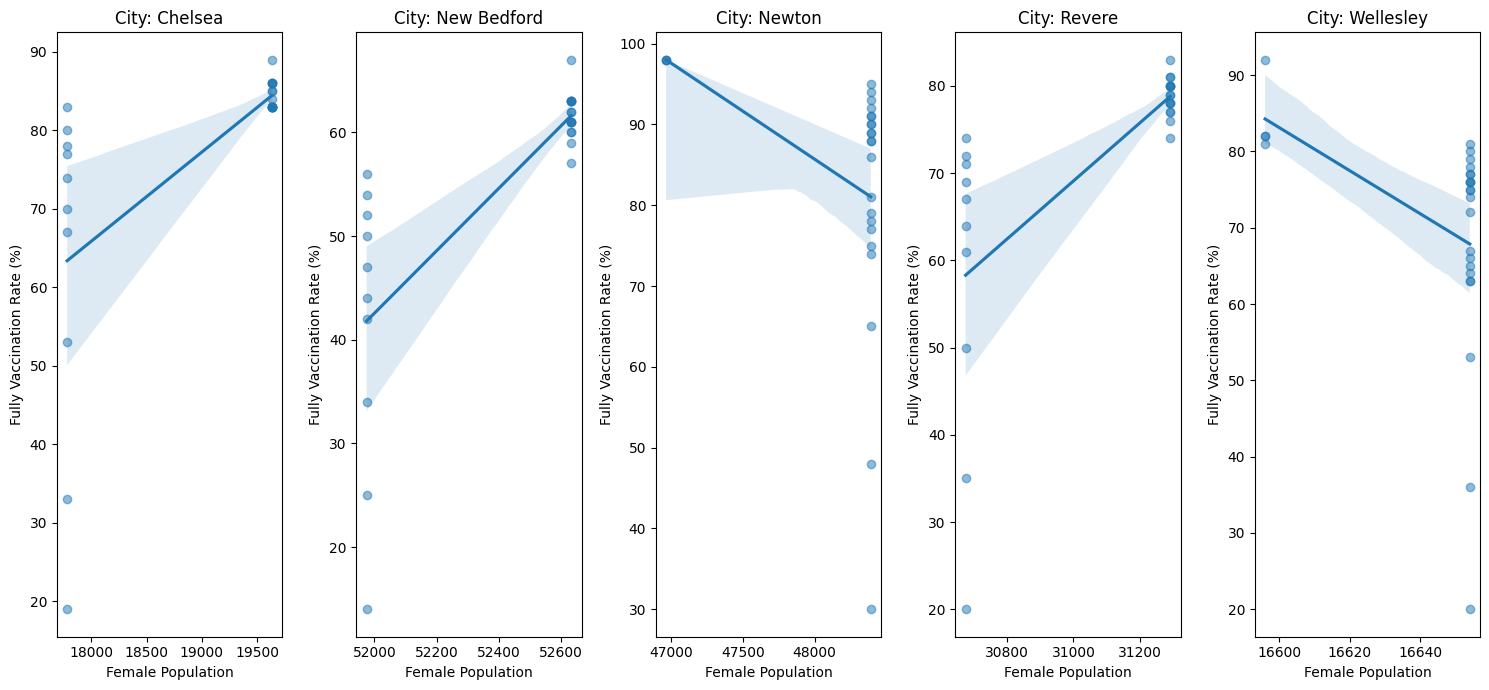

In [382]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the data for females
female_data = new_df[new_df['gender'] == 'Female']

# Get unique cities
cities = female_data['city'].unique()

# Plotting
plt.figure(figsize=(15, 7))  # Adjust the figure size as needed

for i, city in enumerate(cities):
    plt.subplot(1, len(cities), i + 1)  # Create a subplot for each city
    sns.regplot(
        x='population_female',  # Replace with your predictor variable name
        y='fully_vac_rate', 
        data=female_data[female_data['city'] == city],
        scatter_kws={'alpha': 0.5}
    )
    plt.title(f'City: {city}')
    plt.xlabel('Female Population')  # Replace with your predictor variable name
    plt.ylabel('Fully Vaccination Rate (%)')

plt.tight_layout()
plt.show()
